wifiber

# Definition du projet

# importation des librairies

In [1]:
import pandas as pd
import numpy as np

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score



# Collecte des données

In [2]:
daily_june = pd.read_csv("../data/usage_monthly.csv")
reference = pd.read_csv("../data/references_modified.csv", sep=",")
price=pd.read_csv("../data/unique_price.csv", sep=',')

In [3]:
df = daily_june.copy()

# Exploration et visualisation des données

In [4]:
df.head()

,DATE,DA_ID,DA_OFFER,OFFRE,MSISDN,BILL_TYPE,MARKET_TYPE,TARIF_PLAN,OPERATOR,VOLUME,COUNT
0,2024-06-01,1059,3248,be connect 550mo,261320200001,Prepaid,B2C,IZY,Orange,382026752,3
1,2024-06-01,1082,6133,be 5000 new,261320200002,Prepaid,B2C,IZY,Orange,14570496,5
2,2024-06-01,1010,3111,akama full,261320200007,Prepaid,B2C,IZY,Orange,470286336,3
3,2024-06-01,1059,3248,be connect 550mo,261320200007,Prepaid,B2C,IZY,Orange,1048576,2
4,2024-06-01,1097,3251,bonus spotify bc 550mo,261320200007,Prepaid,B2C,IZY,Orange,16384,2


In [5]:
df.shape

(19705907, 11)

In [6]:
reference.head()

,DA_OFFER,DA_ID,OFFRE,QUANTITY,VALIDITY
0,1_0,1,mandam,0.0,""""""
1,2_0,2,mandam,0.0,""""""
2,3_6008,3,be iray,40.0,"""1 jour"""
3,4_6015,4,be roa,3076.0,"""2 jours"""
4,5_6016,5,be mifety,40.0,"""1 jour"""


In [7]:
price.tail()

,OFFRE,PRICE
624,wanna 95000 renouvellement,95000.0
625,wanna 95000,95000.0
626,freefiber 100go,954000.0
627,be mifety,990.0
628,wifiber go+,99000


In [8]:
reference.head()

,DA_OFFER,DA_ID,OFFRE,QUANTITY,VALIDITY
0,1_0,1,mandam,0.0,""""""
1,2_0,2,mandam,0.0,""""""
2,3_6008,3,be iray,40.0,"""1 jour"""
3,4_6015,4,be roa,3076.0,"""2 jours"""
4,5_6016,5,be mifety,40.0,"""1 jour"""


In [9]:
reference[reference["OFFRE"].str.contains("wifiber", case=False)]

,DA_OFFER,DA_ID,OFFRE,QUANTITY,VALIDITY
1178,385_1150,385,wifiber pro start,0.000000e+00,"""30 jours"""
1179,391_1151,391,wifiber pro light,0.000000e+00,"""30 jours"""
1180,392_1152,392,wifiber pro plus,0.000000e+00,"""30 jours"""
1326,1103_4097,1103,wifiber goplus,1.610613e+11,"""30 jours"""


In [10]:
reference.shape

(1394, 5)

In [11]:
reference = pd.merge(reference, price, on="OFFRE", how="left")
# reference = pd.merge(reference, price, on="OFFRE")
reference.head()

,DA_OFFER,DA_ID,OFFRE,QUANTITY,VALIDITY,PRICE
0,1_0,1,mandam,0.0,"""""",690.0
1,2_0,2,mandam,0.0,"""""",690.0
2,3_6008,3,be iray,40.0,"""1 jour""",1000.0
3,3_6008,3,be iray,40.0,"""1 jour""",1000.0
4,4_6015,4,be roa,3076.0,"""2 jours""",2000.0


In [12]:
reference.isnull().sum()

DA_OFFER       2
DA_ID          0
OFFRE          0
QUANTITY       0
VALIDITY       2
PRICE       1186
dtype: int64

In [13]:
reference['DA_OFFER'] = reference['DA_OFFER'].fillna(0.0)
reference['VALIDITY'] = reference['VALIDITY'].replace("", "0 jour")
reference['PRICE'] = reference['PRICE'].fillna(0.0)

In [14]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DA_OFFER  1414 non-null   object 
 1   DA_ID     1414 non-null   int64  
 2   OFFRE     1414 non-null   object 
 3   QUANTITY  1414 non-null   float64
 4   VALIDITY  1412 non-null   object 
 5   PRICE     1414 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 66.4+ KB


In [15]:
reference[reference["OFFRE"].str.contains("wifiber", case=False)]

,DA_OFFER,DA_ID,OFFRE,QUANTITY,VALIDITY,PRICE
1194,385_1150,385,wifiber pro start,0.000000e+00,"""30 jours""",0.0
1195,391_1151,391,wifiber pro light,0.000000e+00,"""30 jours""",0.0
1196,392_1152,392,wifiber pro plus,0.000000e+00,"""30 jours""",0.0
1344,1103_4097,1103,wifiber goplus,1.610613e+11,"""30 jours""",0.0


In [16]:
reference["DA_OFFER"] = reference["DA_OFFER"].astype("int64")

In [17]:
reference = reference.dropna(subset=['VALIDITY'])

In [18]:
reference.shape

(1412, 6)

In [19]:
def convert_to_days(value):
    value = value.strip('"')
    value = value.strip('[')
    if len(value) == 0:
        return 0
    if 'j' in value:
        if len(value.split("jour")[0]) == 0:
            return 0
        return int(value.split('j')[0])
    elif 'heure' in value or 'h' in value:
        return 1
    elif 'mois' in value:
        return int(value.split('mois')[0]) * 30
    return 0

In [20]:
reference['VALIDITY_DAYS'] = reference['VALIDITY'].apply(convert_to_days)

In [21]:
reference["PRICE"] = reference["PRICE"].astype("float")

In [22]:
reference.drop(columns=["VALIDITY"])

,DA_OFFER,DA_ID,OFFRE,QUANTITY,PRICE,VALIDITY_DAYS
0,10,1,mandam,0.0,690.0,0
1,20,2,mandam,0.0,690.0,0
2,36008,3,be iray,40.0,1000.0,1
3,36008,3,be iray,40.0,1000.0,1
4,46015,4,be roa,3076.0,2000.0,2
...,...,...,...,...,...,...
1409,10554151,1055,so smart 15go appel int,900.0,0.0,30
1410,11054152,1105,bonus sms so smart onnet,2300.0,0.0,30
1411,11276242,1127,be sms flex crossnet,200.0,0.0,7
1412,11296243,1129,bonus sms illimités be sms flex onnet,500.0,0.0,1


In [23]:
reference[reference["PRICE"] == 0]

,DA_OFFER,DA_ID,OFFRE,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS
9,80,8,mandam maxi/be fitia,0.0,"""""",0.0,0
19,176036,17,be sms transfert,0.0,jour j minuit,0.0,0
21,196026,19,forfeno,7500.0,"""6 jours""",0.0,6
22,206050,20,mandam (new),500.0,"""1 jour""",0.0,1
26,230,23,akama,0.0,"""""",0.0,0
...,...,...,...,...,...,...,...
1409,10554151,1055,so smart 15go appel int,900.0,"""1 mois""",0.0,30
1410,11054152,1105,bonus sms so smart onnet,2300.0,"""1 mois""",0.0,30
1411,11276242,1127,be sms flex crossnet,200.0,"""7 jours""",0.0,7
1412,11296243,1129,bonus sms illimités be sms flex onnet,500.0,"""21h à 6h""",0.0,1


In [24]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1412 entries, 0 to 1413
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DA_OFFER       1412 non-null   int64  
 1   DA_ID          1412 non-null   int64  
 2   OFFRE          1412 non-null   object 
 3   QUANTITY       1412 non-null   float64
 4   VALIDITY       1412 non-null   object 
 5   PRICE          1412 non-null   float64
 6   VALIDITY_DAYS  1412 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 88.2+ KB


In [25]:
reference[reference["PRICE"] == 0]["OFFRE"].unique()

array(['mandam maxi/be fitia', 'be sms transfert', 'forfeno',
       'mandam (new)', 'akama', 'allowa plus', 'lany credit usage',
       'lany credit fee', 'lany credit remboursement', 'bonus recharge',
       'lms bonus', 'lms bonus-bonus sms vers orange',
       'postpaid default bundle', 'recharge da', 'roaming bundle offer',
       'postpaid credit limit da', 'postpaid credit limit storage da',
       'hybrid credit limit storage da', 'online charging da',
       'offline charging da', 'reference da', 'corporate star 25sms',
       'corporate star 100sms', 'finday naka ii/iii', 'orange rise 31',
       'samsung j1 ace', 'akama 1', 'be dimy tana', 'be iray tana',
       'be mifety tana', 'm2m 250 sms onnet', 'm2m 1000 sms onnet',
       'm2m 5000 sms onnet', 'm2m 10000 sms onnet', 'm2m 100 sms offnet',
       'm2m 250 sms offnet', 'm2m 1000 sms offnet', 'voix intraflotte',
       'corporate star 1h 5h', 'havana proche', 'pro new', 'mifety',
       'facebook flex', 'm2m 15mn onnet', 

In [26]:
daily_june.head()

,DATE,DA_ID,DA_OFFER,OFFRE,MSISDN,BILL_TYPE,MARKET_TYPE,TARIF_PLAN,OPERATOR,VOLUME,COUNT
0,2024-06-01,1059,3248,be connect 550mo,261320200001,Prepaid,B2C,IZY,Orange,382026752,3
1,2024-06-01,1082,6133,be 5000 new,261320200002,Prepaid,B2C,IZY,Orange,14570496,5
2,2024-06-01,1010,3111,akama full,261320200007,Prepaid,B2C,IZY,Orange,470286336,3
3,2024-06-01,1059,3248,be connect 550mo,261320200007,Prepaid,B2C,IZY,Orange,1048576,2
4,2024-06-01,1097,3251,bonus spotify bc 550mo,261320200007,Prepaid,B2C,IZY,Orange,16384,2


In [27]:
reference.to_csv("../data/reference_prepared.csv", index=False)

In [28]:
df_test = pd.merge(daily_june.copy(), reference, on=["DA_ID", "OFFRE"])

In [29]:
df_test.select_dtypes("object").nunique()

DATE            30
OFFRE          235
BILL_TYPE        4
MARKET_TYPE      2
TARIF_PLAN      68
OPERATOR         3
VALIDITY        19
dtype: int64

In [30]:
df_test["BILL_TYPE"].unique()

array(['Prepaid', 'Hybride', 'Postpaid', 'Postpaid Controlle', nan],
      dtype=object)

In [31]:
df_test[~df_test["BILL_TYPE"].isin(['Prepaid', 'Hybride', 'Postpaid', 'Postpaid Controlle'])]

,DATE,DA_ID,DA_OFFER_x,OFFRE,MSISDN,BILL_TYPE,MARKET_TYPE,TARIF_PLAN,OPERATOR,VOLUME,COUNT,DA_OFFER_y,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS
217338,2024-06-03,1059,3248,be connect 550mo,261374020238,NaN,NaN,Bonus Mizara/Tafabe,Orange,160723968,8,10593248,576716800.0,"""7 jours""",3000.0,7
217339,2024-06-03,1059,3248,be connect 550mo,261374020238,NaN,NaN,Bonus Mizara/Tafabe,Orange,160723968,8,10593248,576716800.0,"""7 jours""",3000.0,7
247486,2024-06-04,1059,3248,be connect 550mo,261325030299,NaN,NaN,Bonus Mizara/Tafabe,Orange,568440832,2,10593248,576716800.0,"""7 jours""",3000.0,7
247487,2024-06-04,1059,3248,be connect 550mo,261325030299,NaN,NaN,Bonus Mizara/Tafabe,Orange,568440832,2,10593248,576716800.0,"""7 jours""",3000.0,7
267610,2024-06-04,1059,3248,be connect 550mo,261327417093,NaN,NaN,IZY,Orange,294009856,1,10593248,576716800.0,"""7 jours""",3000.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20629945,2024-06-24,200,3215,bonus mistt,261325310117,NaN,NaN,CMO Premium 10,Orange,207622144,1,2003215,209715200.0,"""24 heures""",0.0,1
20630106,2024-06-28,200,3215,bonus mistt,261325280130,NaN,NaN,CMO Premium 10,Orange,209715200,1,2003215,209715200.0,"""24 heures""",0.0,1
20630161,2024-06-29,200,3215,bonus mistt,261324806911,NaN,NaN,CMO Premium 10,Orange,206610432,2,2003215,209715200.0,"""24 heures""",0.0,1
20630172,2024-06-29,200,3215,bonus mistt,261326177071,NaN,NaN,CMO Premium 10,Orange,75384832,7,2003215,209715200.0,"""24 heures""",0.0,1


In [32]:
df_test[df_test["OFFRE"].str.contains("wifiber", case=False)]["OFFRE"].value_counts()

OFFRE
wifiber pro light    37044
wifiber pro plus     10561
wifiber pro start     5138
Name: count, dtype: int64

In [33]:
df_test[df_test["OFFRE"].str.contains("Discovery", case=False)]["OFFRE"].value_counts()

OFFRE
home discovery    220145
Name: count, dtype: int64

In [34]:
df_test[df_test["OFFRE"].str.contains("Prime", case=False)]["OFFRE"].value_counts()

OFFRE
home prime    49677
Name: count, dtype: int64

In [35]:
df_test[df_test["PRICE"] == 0]["OFFRE"].unique()

array(['bonus spotify bc 550mo', 'be mix 2000 bon plan om',
       'bonus aôonnaaa rahariva/boss: bonus data om', 'be mix 2000 om',
       'wifiber pro light', 'go net 1go', 'smart 4go data',
       'smart 1go data', 'gigapro 10', 'bonus spotify bc 3go',
       'gigapro 3', 'data bundle 500 mo', 'smart 8go data',
       'bonus spotify bc 2go', 'corporate smart 12: data',
       'data bundle 3 go', 'bonus spotify bc 25go', 'go net 8go',
       'bonus spotify bc 5go', 'data 50mo', 'corporate smart 25: data',
       'forfait data 50mo corporate intense', 'gigapro 300',
       'smart 30go data', 'corporate smart ultra: data',
       'wifiber pro plus', 'corporate data bundle 1go-i', 'gigapro 15',
       'corporate smart 6: data', 'bonus spotify bc 1go3jours',
       'gigapro 25', 'smart ultra data', 'data bundle 750 mo',
       'bonus spotify bc 15go', 'data bundle 250 mo',
       'home 130 (old homenet 50)', 'data bundle 50 mo',
       'smart 20go data', 'aôonnaaa maître: data tout intern

In [36]:
df_test[df_test["OFFRE"] == "Isikaray Objectif Bac"]

,DATE,DA_ID,DA_OFFER_x,OFFRE,MSISDN,BILL_TYPE,MARKET_TYPE,TARIF_PLAN,OPERATOR,VOLUME,COUNT,DA_OFFER_y,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS


In [37]:
reference[reference["OFFRE"] == "Isikaray Objectif Bac"]

,DA_OFFER,DA_ID,OFFRE,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS


In [38]:
price[price["OFFRE"] == "Isikaray Objectif Bac"]

,OFFRE,PRICE


In [39]:
df_test[df_test["OFFRE"].str.contains("bac", case=False)]

,DATE,DA_ID,DA_OFFER_x,OFFRE,MSISDN,BILL_TYPE,MARKET_TYPE,TARIF_PLAN,OPERATOR,VOLUME,COUNT,DA_OFFER_y,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS
20639256,2024-06-25,1080,3214,isikaray objectif bac,261329088724,Prepaid,B2C,IZY,Orange,319684608,5,10803214,1.073742e+09,"""30 jours""",0.0,30
20639257,2024-06-28,1080,3214,isikaray objectif bac,261329088724,Prepaid,B2C,IZY,Orange,3833856,2,10803214,1.073742e+09,"""30 jours""",0.0,30


In [40]:
df_test[df_test["OFFRE"].str.contains("wifiber", case=False)]

,DATE,DA_ID,DA_OFFER_x,OFFRE,MSISDN,BILL_TYPE,MARKET_TYPE,TARIF_PLAN,OPERATOR,VOLUME,COUNT,DA_OFFER_y,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS
18159443,2024-06-01,391,1151,wifiber pro light,261320200224,Postpaid,B2B,Internet PRO,Orange,12002286592,1,3911151,0.0,"""30 jours""",0.0,30
18159444,2024-06-01,391,1151,wifiber pro light,261320301047,Postpaid,B2B,Internet PRO,Orange,8192,2,3911151,0.0,"""30 jours""",0.0,30
18159445,2024-06-01,391,1151,wifiber pro light,261320301048,Postpaid,B2B,Internet PRO,Orange,14060013568,1,3911151,0.0,"""30 jours""",0.0,30
18159446,2024-06-01,391,1151,wifiber pro light,261320301135,Postpaid,B2B,Internet PRO,Orange,43705350144,1,3911151,0.0,"""30 jours""",0.0,30
18159447,2024-06-01,391,1151,wifiber pro light,261320301861,Postpaid,B2B,Internet PRO,Orange,291734528,6,3911151,0.0,"""30 jours""",0.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20227374,2024-06-30,385,1150,wifiber pro start,261321291705,Postpaid,B2B,Internet PRO,Orange,20938345472,1,3851150,0.0,"""30 jours""",0.0,30
20227375,2024-06-30,385,1150,wifiber pro start,261321291706,Postpaid,B2B,Internet PRO,Orange,3525346304,2,3851150,0.0,"""30 jours""",0.0,30
20227376,2024-06-30,385,1150,wifiber pro start,261321295159,Postpaid,B2B,Internet PRO,Orange,3943059456,3,3851150,0.0,"""30 jours""",0.0,30
20227377,2024-06-30,385,1150,wifiber pro start,261322361514,Postpaid,B2B,Internet PRO,Orange,5048335360,1,3851150,0.0,"""30 jours""",0.0,30


# Préparation des données

In [41]:
def create_target(row):
    if 250_000 <= row["PRICE"] or row["VOLUME"] > 322122547200:
        return "WIFIBER Prime"
    elif 100_000 <= row["PRICE"] < 250_000 or 161061273600 <= row["VOLUME"] <= 322122547200:
        return "WIFIBER Discovery"
    elif 30_000 <= row["PRICE"] < 100_000 or 91061273600 < row["VOLUME"] < 161061273600:
        return "WIFIBER Go+"
    else:
        return "OTHER"

In [42]:
def most_frequent(lst):
    if all(isinstance(x, int) for x in lst):
        return max(lst)
    if lst:
        return Counter(lst).most_common(1)[0][0]
    else:
        return None

In [43]:
def wrangle(daily_june):
    reference = pd.read_csv("../data/reference_prepared.csv")

    # merge daily_june and reference into one DataFrame
    df = pd.merge(daily_june, reference, on=["DA_ID", "OFFRE"])

    # Group DataFrame by MSISDN
    monthly_usage = df.groupby(['MSISDN']).agg({
        'TARIF_PLAN': 'first',
        'VOLUME': 'sum',
        'QUANTITY': 'sum',
        'VALIDITY_DAYS': list,
        'OFFRE': list,
        "MARKET_TYPE": "first",
        'PRICE': 'sum',
    }).reset_index()

    # get the most frequent offers in each client
    monthly_usage['most_frequent'] = monthly_usage['OFFRE'].apply(most_frequent)
    monthly_usage['longest_days'] = monthly_usage['VALIDITY_DAYS'].apply(most_frequent)
    
    # change value
    # df['OFFRE'] = df['OFFRE'].replace('HOME Discovery', 'WIFIBER Discovery')
    # df['OFFRE'] = df['OFFRE'].replace('HOME Prime', 'WIFIBER Prime')
    # monthly_usage['most_frequent'] = monthly_usage['most_frequent'].replace('HOME Discovery', 'WIFIBER Discovery')
    # monthly_usage['most_frequent'] = monthly_usage['most_frequent'].replace('HOME Prime', 'WIFIBER Prime')

    # Drop leacky columns
    df.drop(columns=["DA_OFFER_x", "DA_OFFER_y"], inplace=True)

    # Drop high-cardinality and low-cardinality categorical columns
    df.drop(columns=["OPERATOR"], inplace=True)

    # Drop unused columns
    df.drop(columns=["BILL_TYPE"], inplace=True)
    monthly_usage.drop(columns=["VALIDITY_DAYS", "OFFRE"], inplace=True)

    # Create target column
    # df["PROPOSITION"] = df.apply(create_target, axis=1)    
    monthly_usage["PROPOSITION"] = monthly_usage.apply(create_target, axis=1)    


    return df, monthly_usage

In [44]:
df, monthly_usage = wrangle(daily_june.copy())

In [45]:
df.head()

,DATE,DA_ID,OFFRE,MSISDN,MARKET_TYPE,TARIF_PLAN,VOLUME,COUNT,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS
0,2024-06-01,1059,be connect 550mo,261320200001,B2C,IZY,382026752,3,576716800.0,"""7 jours""",3000.0,7
1,2024-06-01,1059,be connect 550mo,261320200001,B2C,IZY,382026752,3,576716800.0,"""7 jours""",3000.0,7
2,2024-06-01,1059,be connect 550mo,261320200007,B2C,IZY,1048576,2,576716800.0,"""7 jours""",3000.0,7
3,2024-06-01,1059,be connect 550mo,261320200007,B2C,IZY,1048576,2,576716800.0,"""7 jours""",3000.0,7
4,2024-06-01,1059,be connect 550mo,261320200112,B2C,IZY,38572032,2,576716800.0,"""7 jours""",3000.0,7


In [46]:
df[df["OFFRE"].str.contains("wifiber", case=False)]

,DATE,DA_ID,OFFRE,MSISDN,MARKET_TYPE,TARIF_PLAN,VOLUME,COUNT,QUANTITY,VALIDITY,PRICE,VALIDITY_DAYS
18159443,2024-06-01,391,wifiber pro light,261320200224,B2B,Internet PRO,12002286592,1,0.0,"""30 jours""",0.0,30
18159444,2024-06-01,391,wifiber pro light,261320301047,B2B,Internet PRO,8192,2,0.0,"""30 jours""",0.0,30
18159445,2024-06-01,391,wifiber pro light,261320301048,B2B,Internet PRO,14060013568,1,0.0,"""30 jours""",0.0,30
18159446,2024-06-01,391,wifiber pro light,261320301135,B2B,Internet PRO,43705350144,1,0.0,"""30 jours""",0.0,30
18159447,2024-06-01,391,wifiber pro light,261320301861,B2B,Internet PRO,291734528,6,0.0,"""30 jours""",0.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...
20227374,2024-06-30,385,wifiber pro start,261321291705,B2B,Internet PRO,20938345472,1,0.0,"""30 jours""",0.0,30
20227375,2024-06-30,385,wifiber pro start,261321291706,B2B,Internet PRO,3525346304,2,0.0,"""30 jours""",0.0,30
20227376,2024-06-30,385,wifiber pro start,261321295159,B2B,Internet PRO,3943059456,3,0.0,"""30 jours""",0.0,30
20227377,2024-06-30,385,wifiber pro start,261322361514,B2B,Internet PRO,5048335360,1,0.0,"""30 jours""",0.0,30


In [47]:
df[df["OFFRE"].str.contains("wifiber", case=False)].value_counts()

DATE        DA_ID  OFFRE              MSISDN        MARKET_TYPE  TARIF_PLAN    VOLUME       COUNT  QUANTITY  VALIDITY    PRICE  VALIDITY_DAYS
2024-06-01  385    wifiber pro start  261320303507  B2B          Internet PRO  3734109184   1      0.0       "30 jours"  0.0    30               1
2024-06-21  385    wifiber pro start  261320501287  B2B          Internet PRO  7988965376   2      0.0       "30 jours"  0.0    30               1
                                      261320378626  B2B          Internet PRO  5088692224   1      0.0       "30 jours"  0.0    30               1
                                      261320378905  B2B          Internet PRO  3563294720   4      0.0       "30 jours"  0.0    30               1
                                      261320385930  B2B          Internet PRO  4175763456   5      0.0       "30 jours"  0.0    30               1
                                                                                                                           

In [48]:
monthly_usage.head()

,MSISDN,TARIF_PLAN,VOLUME,QUANTITY,MARKET_TYPE,PRICE,most_frequent,longest_days,PROPOSITION
0,261320200001,IZY,11845357568,3.460301e+10,B2C,180000.0,be connect 550mo,7,WIFIBER Discovery
1,261320200002,IZY,392058880,4.131389e+09,B2C,127000.0,be 10000 new,30,WIFIBER Discovery
2,261320200003,IZY,103912448,8.808038e+08,B2C,4000.0,akama up,1,OTHER
3,261320200007,IZY,8810780672,1.470104e+10,B2C,66000.0,akama full,7,WIFIBER Go+
4,261320200011,IZY,51992576,1.048576e+08,B2C,500.0,akama up,1,OTHER


In [49]:
monthly_usage[monthly_usage["most_frequent"].str.contains("wifiber pro", case=False)]

,MSISDN,TARIF_PLAN,VOLUME,QUANTITY,MARKET_TYPE,PRICE,most_frequent,longest_days,PROPOSITION
58,261320200224,Internet PRO,406607090688,0.0,B2B,0.0,wifiber pro light,30,WIFIBER Prime
108,261320200451,Internet PRO,51581876224,0.0,B2B,0.0,wifiber pro plus,30,OTHER
1340,261320206335,Internet PRO,238141433856,0.0,B2B,0.0,wifiber pro plus,30,WIFIBER Discovery
19723,261320301047,Internet PRO,137481606144,0.0,B2B,0.0,wifiber pro light,30,WIFIBER Go+
19724,261320301048,Internet PRO,247149955072,0.0,B2B,0.0,wifiber pro light,30,WIFIBER Discovery
...,...,...,...,...,...,...,...,...,...
744854,261326641278,Internet PRO,427859723264,0.0,B2B,0.0,wifiber pro light,30,WIFIBER Prime
846035,261327386868,Internet PRO,22587138048,0.0,B2B,0.0,wifiber pro light,30,OTHER
935473,261328028142,Internet PRO,394186717184,0.0,B2B,0.0,wifiber pro start,30,WIFIBER Prime
1190710,261329959979,Internet PRO,493720759296,0.0,B2B,0.0,wifiber pro light,30,WIFIBER Prime


In [50]:
monthly_usage[monthly_usage["most_frequent"].str.contains("HOME", case=False)]


,MSISDN,TARIF_PLAN,VOLUME,QUANTITY,MARKET_TYPE,PRICE,most_frequent,longest_days,PROPOSITION
56,261320200218,Wifiber,321753564160,3.298535e+13,B2C,4770000.0,home discovery,30,WIFIBER Prime
60,261320200229,Wifiber,296877533184,3.298535e+13,B2C,4770000.0,home discovery,30,WIFIBER Prime
62,261320200231,Wifiber,335776995328,3.298535e+13,B2C,4770000.0,home discovery,30,WIFIBER Prime
103,261320200433,Wifiber,160092897280,3.298535e+13,B2C,4770000.0,home discovery,30,WIFIBER Prime
217,261320200981,Wifiber,202319453184,2.968681e+13,B2C,4293000.0,home discovery,30,WIFIBER Prime
...,...,...,...,...,...,...,...,...,...
1242233,261378188512,Homenet Prepaye,11417152512,4.724464e+11,B2C,860000.0,home confort new,30,WIFIBER Prime
1242235,261378188520,IZY,43056413696,1.685806e+12,B2C,3610000.0,home confort new,30,WIFIBER Prime
1242236,261378188521,Homenet Prepaye,117664851968,1.417339e+12,B2C,2580000.0,home confort new,30,WIFIBER Prime
1242608,261378191866,Homenet Prepaye,368116336640,3.543348e+12,B2C,6450000.0,home confort new,30,WIFIBER Prime


In [51]:
monthly_usage["most_frequent"].value_counts().head()

most_frequent
akama plus          270303
akama up            266230
be 500 new          262575
be 1000 new         131015
be connect 550mo     70440
Name: count, dtype: int64

In [52]:
monthly_usage["longest_days"].value_counts()

longest_days
1      809688
7      120740
30     116681
3       99375
2       73074
5       22948
15        574
10        269
90         69
180        46
0           4
Name: count, dtype: int64

In [53]:
monthly_usage[monthly_usage["most_frequent"].str.contains("wifiber", case=False)]["most_frequent"].value_counts()

most_frequent
wifiber pro light    1371
wifiber pro plus      381
wifiber pro start     181
Name: count, dtype: int64

In [54]:
monthly_usage.select_dtypes("object").nunique()

TARIF_PLAN        68
MARKET_TYPE        2
most_frequent    213
PROPOSITION        4
dtype: int64

In [55]:
monthly_usage["TARIF_PLAN"].value_counts()

TARIF_PLAN
IZY                  1156395
Forfait M2M            11561
CMO Data               10885
Wifiber                 9499
Orange d                6857
                      ...   
So Smart                   2
Smart Pro PRODIGY          2
Premium 3                  2
SMM CMO                    1
Orange Net                 1
Name: count, Length: 68, dtype: int64

In [56]:
monthly_usage[monthly_usage["PROPOSITION"].str.contains("HOME DISCOVERY", case=False)]

,MSISDN,TARIF_PLAN,VOLUME,QUANTITY,MARKET_TYPE,PRICE,most_frequent,longest_days,PROPOSITION


In [57]:
monthly_usage["PROPOSITION"].value_counts()

PROPOSITION
OTHER                978826
WIFIBER Go+          145242
WIFIBER Prime         60715
WIFIBER Discovery     58685
Name: count, dtype: int64

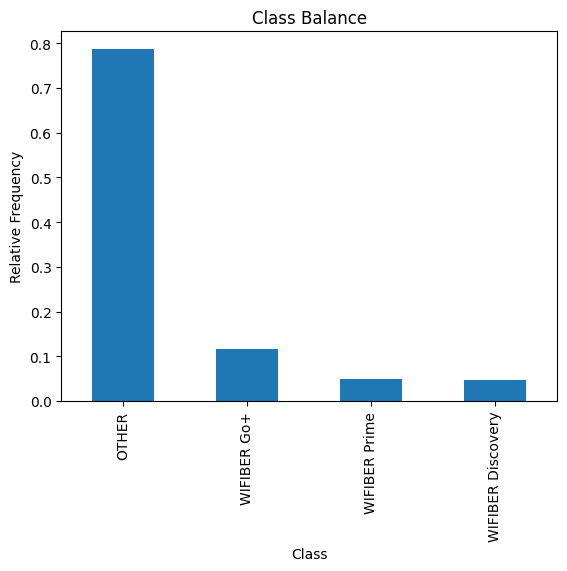

In [58]:
monthly_usage["PROPOSITION"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

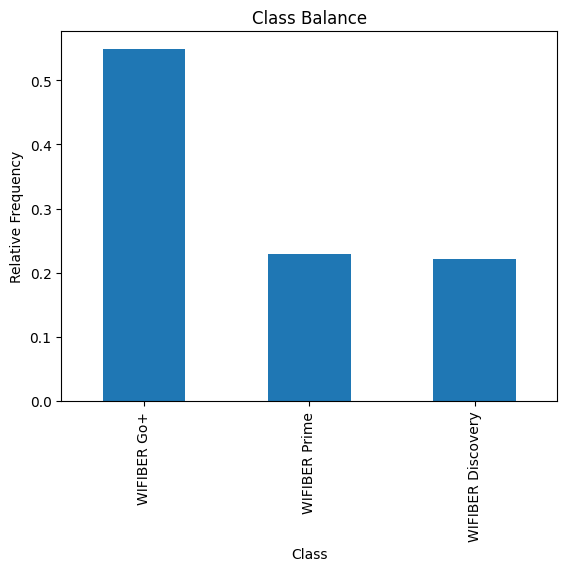

In [59]:
monthly_usage[monthly_usage["PROPOSITION"] != "OTHER"]["PROPOSITION"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

In [60]:
monthly_usage.select_dtypes("object").nunique()

TARIF_PLAN        68
MARKET_TYPE        2
most_frequent    213
PROPOSITION        4
dtype: int64

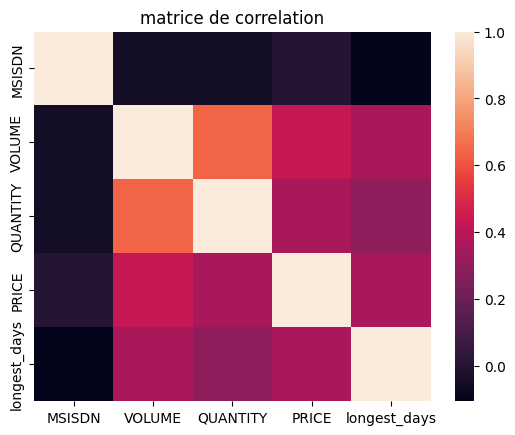

In [61]:
# Create correlation matrix
correlation = monthly_usage.select_dtypes("number").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation)
plt.title("matrice de correlation");

Text(0.5, 1.0, 'Distribution of quantity by proposition')

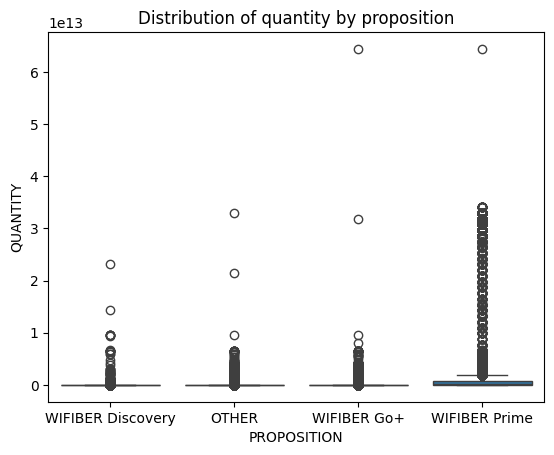

In [62]:
# Create boxplot
sns.boxplot(x="PROPOSITION", y="QUANTITY", data=monthly_usage)
# Label axes
plt.xlabel("PROPOSITION")
plt.ylabel("QUANTITY")
plt.title("Distribution of quantity by proposition")

In [63]:
monthly_usage.describe()

,MSISDN,VOLUME,QUANTITY,PRICE,longest_days
count,1.243468e+06,1.243468e+06,1.243468e+06,1.243468e+06,1.243468e+06
mean,2.613272e+11,5.911765e+09,2.685020e+11,2.027869e+05,4.616203e+00
std,9.694666e+06,3.112734e+10,2.762563e+12,1.420432e+06,8.469984e+00
min,2.613202e+11,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.613230e+11,2.621440e+07,1.468006e+08,1.000000e+03,1.000000e+00
50%,2.613257e+11,4.676639e+08,9.437184e+08,5.500000e+03,1.000000e+00
75%,2.613280e+11,2.652420e+09,4.802478e+09,2.300000e+04,3.000000e+00
max,2.613800e+11,3.012190e+12,6.442451e+13,1.292890e+08,1.800000e+02


In [64]:
monthly_usage[monthly_usage["TARIF_PLAN"].str.contains("Go net", case=False)]

,MSISDN,TARIF_PLAN,VOLUME,QUANTITY,MARKET_TYPE,PRICE,most_frequent,longest_days,PROPOSITION
49759,261320500031,Go Net,4539756544,1.610613e+11,B2C,694440.0,go net 5go,30,WIFIBER Prime
49839,261320500209,Go Net,5368814592,3.758096e+10,B2C,162036.0,go net 5go,30,WIFIBER Discovery
49884,261320500354,Go Net,7824428032,8.514437e+10,B2C,385220.0,go net 5go,30,WIFIBER Prime
49985,261320500589,Go Net,4159321088,9.126806e+10,B2C,393516.0,go net 5go,30,WIFIBER Prime
50001,261320500682,Go Net,4434223104,1.288490e+11,B2C,555552.0,go net 5go,30,WIFIBER Prime
...,...,...,...,...,...,...,...,...,...
911889,261327848596,Go Net,842113024,9.663676e+10,B2C,555570.0,go net 3go,30,WIFIBER Prime
1195689,261370234646,Go Net,9074630656,6.872367e+10,B2C,315776.0,go net 5go,30,WIFIBER Prime
1195755,261370263605,Go Net,4110315520,2.684355e+10,B2C,115740.0,go net 5go,30,WIFIBER Discovery
1196741,261370772405,Go Net,21632000,9.663676e+10,B2C,555570.0,go net 3go,30,WIFIBER Prime


# Selection et entraînement du modèle

In [65]:
target = "PROPOSITION"
X = monthly_usage.drop(columns=[target])
y = monthly_usage[target]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [68]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((795819, 8), (795819,), (248694, 8), (248694,))

## Baseline

In [69]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.79


## LogisticRegression

In [70]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)

In [71]:
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['TARIF_PLAN', 'MARKET_TYPE',
                                     'most_frequent'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [72]:
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
# acc_test = accuracy_score(y_test, model.predict(X_test))
acc_test = model_lr.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.95
Test Accuracy: 0.95


## DecisionTreeClassifier

In [73]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)

In [74]:
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['TARIF_PLAN', 'MARKET_TYPE',
                                      'most_frequent'],
                                mapping=[{'col': 'TARIF_PLAN',
                                          'data_type': dtype('O'),
                                          'mapping': IZY                   1
Corporate Smart 6     2
CMO Data              3
Forfait M2M           4
Orange d              5
                     ..
Orange 3G            65
SMM CMO              66
So Smart             67
Orange Net           68
NaN                  -2
Length: 69, dtype: int64},
                                         {'col': 'MARKET_TYPE',
                                          'data_type': dtype('O'),
                                          'mapping': B2C    1
B2B    2
NaN    3
dtype: int64},
                                         {'col': 'most_frequent',
                                          'data_type': dtype('O'),
                                          'mapping': akama plus                 1
akama up                   2
be 1000 new                3
be connect 550mo           4
be 500 new                 5
                        ... 
pass 2 semaines          200
bonus spotify bc 2go     201
bonus spotify bc 25go    202
business wifimob500      203
NaN                       -2
Length: 204, dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [75]:
acc_train = accuracy_score(y_train, model_dt.predict(X_train))
# acc_test = accuracy_score(y_test, model.predict(X_test))
acc_test = model_dt.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 1.0
Test Accuracy: 1.0


## RandomForestClassifier

In [76]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)

In [77]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['TARIF_PLAN', 'MARKET_TYPE',
                                      'most_frequent'],
                                mapping=[{'col': 'TARIF_PLAN',
                                          'data_type': dtype('O'),
                                          'mapping': IZY                   1
Corporate Smart 6     2
CMO Data              3
Forfait M2M           4
Orange d              5
                     ..
Orange 3G            65
SMM CMO              66
So Smart             67
Orange Net           68
NaN                  -2
Length: 69, dtype: int64},
                                         {'col': 'MARKET_TYPE',
                                          'data_type': dtype('O'),
                                          'mapping': B2C    1
B2B    2
NaN    3
dtype: int64},
                                         {'col': 'most_frequent',
                                          'data_type': dtype('O'),
                                          'mapping': akama plus                 1
akama up                   2
be 1000 new                3
be connect 550mo           4
be 500 new                 5
                        ... 
pass 2 semaines          200
bonus spotify bc 2go     201
bonus spotify bc 25go    202
business wifimob500      203
NaN                       -2
Length: 204, dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [78]:
acc_train = accuracy_score(y_train, model_rf.predict(X_train))
# acc_test = accuracy_score(y_test, model_rf.predict(X_test))
acc_test = model_rf.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 1.0
Test Accuracy: 1.0


## hyperparameter

In [79]:
depth_hyperparams = range(1, 50, 2)

In [80]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_test, y_test))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.9030721809858775, 0.9994609326995209, 1.0]
Validation Accuracy Scores: [0.9027841443701898, 0.9994973742832557, 0.9999959789942661]


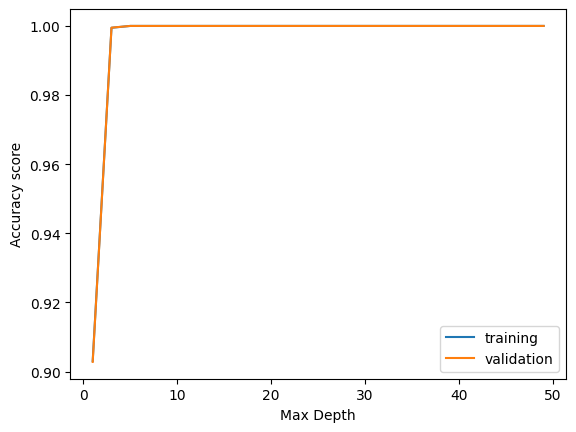

In [81]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

#### gridsearchcv

In [82]:
param_grid = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [None, 10, 20, 30],
    'decisiontreeclassifier__min_samples_split': [2, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [1, 5, 10] 
}

In [83]:
# Création du modèle DecisionTreeClassifier
model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)

In [84]:
# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [85]:
# Exécution de GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [None, 10, 20,
                                                               30],
                         'decisiontreeclassifier__min_samples_leaf': [1, 5, 10],
                         'decisiontreeclassifier__min_samples_split': [2, 10,
                                                                       20]},
             scoring='accuracy')

In [86]:
# Affichage des meilleurs hyperparamètres trouvés
f"Best parameters found: {grid_search.best_params_}"

"Best parameters found: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}"

In [87]:
# Prédictions sur le jeu de test avec le meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [88]:
# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 1.00


### Communicate

In [89]:
# # Create larger figure
# fig, ax = plt.subplots(figsize=(25, 12))
# # Plot tree
# plot_tree(
#     decision_tree=test_model.named_steps["decisiontreeclassifier"],
#     feature_names=X_train.columns.to_list(),
#     filled=True,  # Color leaf with class
#     rounded=True,  # Round leaf edges
#     proportion=True,  # Display proportion of classes in leaf
#     max_depth=3,  # Only display first 3 levels
#     fontsize=12,  # Enlarge font
#     ax=ax,  # Place in figure axis
# );

In [90]:
features = X_train.columns
importances = best_model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3], features.shape)
print("Importances:", importances[:3], importances.shape)

Features: Index(['MSISDN', 'TARIF_PLAN', 'VOLUME'], dtype='object') (8,)
Importances: [0.         0.         0.01202507] (8,)


In [91]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

MSISDN           0.0
TARIF_PLAN       0.0
QUANTITY         0.0
MARKET_TYPE      0.0
most_frequent    0.0
dtype: float64

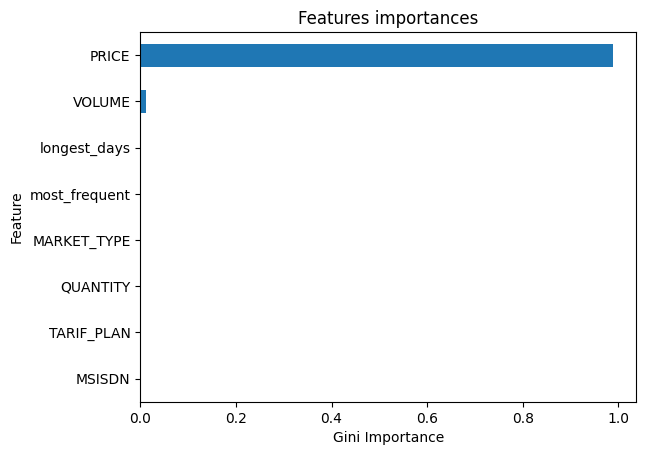

In [92]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Features importances")
plt.show()

# Enregistrer le modèle DecisionTreeClassifier

In [93]:
import pickle

with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [94]:
# Charger le modèle depuis le fichier pickle
with open('decision_tree_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Vérification que le modèle chargé fonctionne correctement
loaded_y_pred = loaded_model.predict(X_test)
loaded_accuracy = accuracy_score(y_test, loaded_y_pred)
print(f'Loaded model accuracy: {loaded_accuracy}')

Loaded model accuracy: 0.9999959789942661


In [95]:
X_test.to_csv("../data/test.csv", index=False)

In [96]:
loaded_y_pred

array(['OTHER', 'OTHER', 'OTHER', ..., 'WIFIBER Discovery', 'WIFIBER Go+',
       'OTHER'], dtype=object)

In [97]:
resultat = pd.DataFrame()
resultat["MSISDN"] = X_test["MSISDN"]
resultat["OFFRE"] = loaded_y_pred
resultat.tail(10)

,MSISDN,OFFRE
2702,261320212698,OTHER
1215950,261372737165,OTHER
126576,261321324705,OTHER
1226721,261374015257,OTHER
461095,261324516509,OTHER
29533,261320385863,WIFIBER Prime
559308,261325238415,OTHER
624711,261325720330,WIFIBER Discovery
1084559,261329169180,WIFIBER Go+
1005451,261328558921,OTHER


In [98]:
resultat.to_csv("../data/resultat.csv")

In [99]:
loaded_y_pred

array(['OTHER', 'OTHER', 'OTHER', ..., 'WIFIBER Discovery', 'WIFIBER Go+',
       'OTHER'], dtype=object)

In [100]:
X_test.columns

Index(['MSISDN', 'TARIF_PLAN', 'VOLUME', 'QUANTITY', 'MARKET_TYPE', 'PRICE',
       'most_frequent', 'longest_days'],
      dtype='object')

In [101]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248694 entries, 186679 to 1005451
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MSISDN         248694 non-null  int64  
 1   TARIF_PLAN     248694 non-null  object 
 2   VOLUME         248694 non-null  int64  
 3   QUANTITY       248694 non-null  float64
 4   MARKET_TYPE    248594 non-null  object 
 5   PRICE          248694 non-null  float64
 6   most_frequent  248694 non-null  object 
 7   longest_days   248694 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 17.1+ MB


In [102]:
import pandas as pd
import pickle

# Charger le modèle depuis le fichier pickle
with open('decision_tree_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Exemple de nouvelles données (doivent être prétraitées de la même manière que les données d'entraînement)
new_data = pd.DataFrame({
    "MSISDN": "261323203232",
    'TARIF_PLAN': ['Izy'],
    'VOLUME': [100000],
    'QUANTITY': [180000],
    'MARKET_TYPE': ['B2C'],
    'PRICE': [200000],
    'most_frequent': ['akama plus'],
    'longest_days': [30],
})

# Faire des prédictions
predictions = loaded_model.predict(new_data)

print("Prédictions :", predictions)


Prédictions : ['WIFIBER Discovery']
